In [2]:
import json
import numpy as np
from langchain_core.tools import tool
from typing import Annotated, List, Optional
from langgraph.prebuilt import InjectedState
import os
import sqlite3
import ast
import pandas as pd

In [5]:
def load_data_to_dataframe(db_name, table_name):
    # Load the entire table into a DataFrame
    conn = sqlite3.connect(db_name)
    df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    conn.close()
    return df

def DCA_tool(
    userID: Annotated[str, InjectedState("userID")],
    table_name: Annotated[str, "Table containing the info"],
    column_name: Annotated[str, "The name of the columns"],
    extend_length: Annotated[Optional[int], "The length by which to extend the forecasted production profile."] = None,
    shut_signal: Annotated[Optional[List[float]], "The signal data for shut-in periods, if applicable."] = None,
    peak_t: Annotated[Optional[int], "The time at which peak production occurs."] = None
    ) -> Annotated[str, "JSON containing the fitted curve, initial decline rate (Di), and b-factor."]:
    """
    Performs Decline Curve Analysis (DCA) to fit a production profile. (cannot be used for predictions from geo properties)
    """
    
    print('Performming DCA')
    db_name = r"E:\OneDriveCopy\AgentOnlineTest1004\AgentOnlineTest\backend\database\user_2024_11_01T04_16_35.db"
    
    df = load_data_to_dataframe(db_name, table_name)
    input_seq = df[column_name].tolist()
    input_seq = [float(item) for item in input_seq]
    
    return input_seq

In [6]:
import ast
user_ID = "user_2024_10_25T18_34_57"
column_name = "CDGas_MCFPerDAY"
table_name="testing_production_data_extract_gas_rate"
input_seq = DCA_tool (user_ID,table_name, column_name)
print(input_seq)

Performming DCA
[732.0, 2425.0, 1759.0, 2200.0, 2230.0, 2149.0, 2021.0, 2338.0, 2472.0, 2662.0, 2506.0, 2037.0, 2242.0, 1984.0, 663.0, 0.0, 0.0, 0.0, 965.0, 1579.0, 1974.0, 1514.0, 1527.0, 1288.0, 1177.0, 1090.0, 1061.0, 855.0, 902.0, 911.0, 834.0, 879.0, 821.0, 556.0, 817.0, 608.0, 591.0, 608.0, 572.0, 586.0, 612.0, 543.0, 536.0, 512.0, 440.0, 622.0, 587.0, 586.0, 550.0, 550.0, 594.0, 561.0, 656.0, 477.0, 461.0, 468.0, 499.0, 456.0, 337.0, 461.0, 493.0, 248.0, 549.0, 451.0, 440.0, 397.0, 446.0, 178.0, 0.0, 675.0, 321.0, 238.0, 434.0, 380.0, 328.0, 425.0, 355.0, 373.0, 328.0, 354.0, 334.0, 323.0]


In [6]:
import json
from langchain_core.tools import tool
import uuid
from typing import Annotated, Optional, Tuple
from langgraph.prebuilt import InjectedState
import os
import pandas as pd
import sqlite3
import ast
from pykrige.ok import OrdinaryKriging
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
def geostats_interpolation(userID: Annotated[str, InjectedState("userID")],
                           rowid: Annotated[str, "The row in the running table containing the property to interpolate"],
                           lati_col_name: Annotated[str, "The column for latitude values"],
                           longi_col_name: Annotated[str, "The column for longitude values"],
                           property_col_name: Annotated[str, "The column for the feature to interpolate"],
                           target_mesh: Annotated[Optional[list[int]], "The output mesh size for the interpolated model, e.g., [20, 20]"]):
    """
    Perform 2D geostatistical interpolation, converting scattered points into a Cartesian mesh using Kriging.

    Inputs:
    - userID: The user's unique identifier.
    - rowid: The ID in the database to retrieve data.
    - lati_col_name, longi_col_name, property_col_name: Columns for latitude, longitude, and the target feature.
    - target_mesh: Int list specifying grid size for interpolation, e.g., [20, 20].

    Output:
    - JSON object containing the generated image URL and a success message.
    """
    try:
        # Database connection and data extraction
        db_name = r"E:\OneDriveCopy\AgentOnlineTest1004\AgentOnlineTest\backend\database\user_2024_10_25T22_50_39.db"
        conn = sqlite3.connect(db_name)
        cursor = conn.cursor()
        table_name = "running"
        
        cursor.execute(f"SELECT data FROM {table_name} WHERE rowid = ?", (rowid,))
        row = cursor.fetchone()
        if not row:
            return json.dumps({"error": "No data found for the given rowid"})
        
        # Extracting data
        data = row[0]
        dictionary = ast.literal_eval(data)
        latitudes = [float(val) for val in dictionary[lati_col_name]]
        longitudes = [float(val) for val in dictionary[longi_col_name]]
        properties = [float(val) for val in dictionary[property_col_name]]
        
        # Variogram model configuration
        variogram_model = 'gaussian'
        variogram_parameters = {
            'sill': 1.0,
            'range': 0.5,
            'nugget': 0.1
        }

        # Kriging model instantiation
        kriging_model = OrdinaryKriging(
            longitudes, latitudes, properties,
            variogram_model=variogram_model,
            verbose=False,
            enable_plotting=False,
            variogram_parameters=variogram_parameters
        )
        
        # Creating the grid for interpolation
        grid_x = target_mesh[0] if target_mesh else 20
        grid_y = target_mesh[1] if target_mesh else 20
        lon_loc = [min(longitudes) + i * (max(longitudes) - min(longitudes)) / (grid_x - 1) for i in range(grid_x)]
        lat_loc = [min(latitudes) + i * (max(latitudes) - min(latitudes)) / (grid_y - 1) for i in range(grid_y)]
        
        # Execute interpolation
        z, ss = kriging_model.execute("grid", lon_loc, lat_loc)

        return lon_loc, lat_loc, z

    except Exception as e:
        print(str(e))
        return json.dumps({"error": f"Error: {str(e)}"})


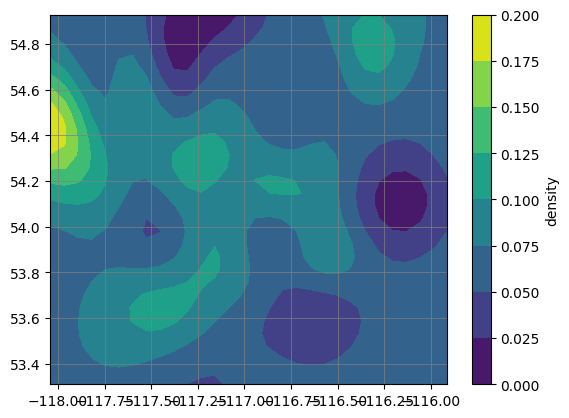

In [32]:
# E:\OneDriveCopy\AgentOnlineTest1004\AgentOnlineTest\backend\database\user_2024_10_25T22_50_39.db
user_ID = "user_2024_10_25T22_50_39"
lon_loc, lat_loc, z = geostats_interpolation(user_ID, "6","Latitude","Longitude","DensityPorosity_PCT",[30,30])

# Plotting the results
plt.contourf(lon_loc, lat_loc, z, cmap="viridis")
plt.colorbar(label='density')
plt.grid(True, color="gray", linestyle="-", linewidth=0.5)
plt.show()

In [28]:
plt.contourf(lon_loc, lat_loc, z, cmap="viridis")
plt.show

<function matplotlib.pyplot.show(*, block=None)>

In [27]:
import json
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from typing import Annotated, Optional, Union, List
import sys
import os 
# Absolute path to the "src" directory containing the modules
src_path = r"E:\OneDriveCopy\AgentOnlineTest1004\AgentOnlineTest\backend\src"
sys.path.append(src_path)

# Now you can import from backend.src.integrations.APIfunctions.geo_pred
from integrations.APIfunctions.geo_pred import geo_pred_Montney

##########################################
####### Pretrained GeoPredict Tool #######
##########################################
def geopred_conv_source(play: Annotated[str, "Play name, e.g., Montney, Duvernay"],
                        longitude: Annotated[float, "Well longitude"],
                        latitude: Annotated[float, "Well latitude"],
                        interval: Annotated[str, "The interval"],
                        startYear: Annotated[int, "Year"],
                        month: Annotated[int, "Month"]):
    """
    Predicts geological features for Central Montney and Duvernay wells based on input coordinates and play name.
    The play must be selected from: [Montney, Duvernay].
    """

    # Prepare the model input
    model_input = {
        "Longitude": longitude,
        "Latitude": latitude,
        "ENVInterval": interval,
        "StartYear": startYear,
        "Month": month
    }

    # Load region edge data from JSON file
    try:
        with open("E:/OneDriveCopy/AgentOnlineTest1004/AgentOnlineTest/backend/src/integrations/pretrained/play_region.json") as f:
            play_regions = json.load(f)

        play_edge = play_regions.get(play)
        
        # Check if play edge data exists for the specified play
        if play_edge is None:
            return json.dumps("Play not found in region data. Please check the play name.")
    except FileNotFoundError:
        return json.dumps("Region data file not found.")

    # Convert region boundary points to a Polygon
    region_polygon = Polygon(play_edge)  # Assuming play_edge is a list of (longitude, latitude) tuples

    # Plot the region boundary and well location
    plt.figure(figsize=(8, 6))
    y, x = zip(*play_edge)
    plt.fill(x, y, color='lightblue', alpha=0.5, label=f"{play} Region Boundary")
    plt.scatter(longitude, latitude, color='red', label="Well Location")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"{play} Region and Well Location")
    plt.legend()
    plt.show()

    # Check if the well location is within the region
    well_point = Point(latitude,longitude)
    if not region_polygon.contains(well_point):
        return json.dumps("Out of range, input again")

    # Perform prediction based on the play
    if play == "Montney":
        pred_results = geo_pred_Montney(model_input)
    else:
        return json.dumps("No such region")

    return json.dumps(pred_results)

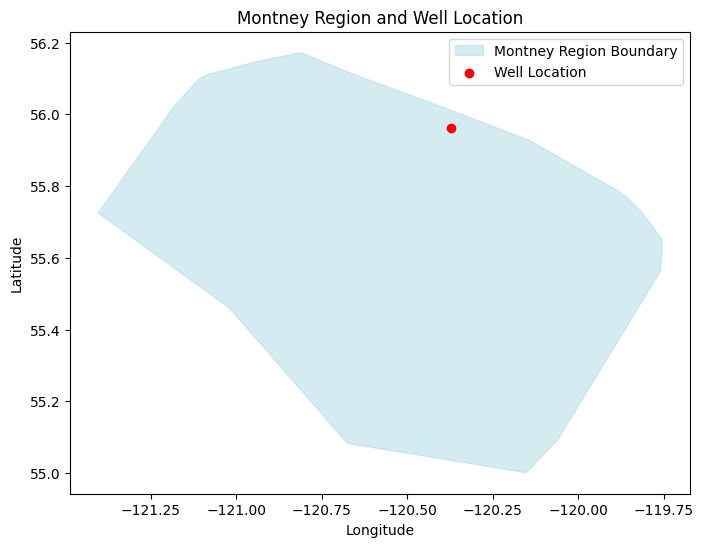

FileNotFoundError: [Errno 2] No such file or directory: 'src/integrations/pretrained/multi_gbr_regressor_noscale.joblib'

In [28]:
results = geopred_conv_source(play = "Montney",
                        longitude = -120.37108,
                        latitude= 55.962475,
                        interval= "LOWER MONTNEY A", 
                        startYear= 2014,
                        month=1)

In [36]:
wells = ['100/08-09-062-25W5/00',
'100/16-36-064-21W5/00',
'102/15-04-063-23W5/00',
'100/05-13-063-20W5/00']

In [39]:
subset = df[df['API_UWI'] == well]
subset

,API_UWI,CDLiquids_BBLPerDAY,CDGas_MCFPerDAY,CDWater_BBLPerDAY,ProducingMonth,TotalProdMonths
2527,100/05-13-063-20W5/00,45.0,172.0,31.0,2017-02-01,1
2528,100/05-13-063-20W5/00,0.0,337.0,119.0,2017-03-01,2
2529,100/05-13-063-20W5/00,2.0,1472.0,307.0,2017-04-01,3
2530,100/05-13-063-20W5/00,6.0,1180.0,227.0,2017-05-01,4
2531,100/05-13-063-20W5/00,0.0,1491.0,227.0,2017-06-01,5
...,...,...,...,...,...,...
2612,100/05-13-063-20W5/00,0.0,216.0,15.0,2024-03-01,86
2613,100/05-13-063-20W5/00,0.0,211.0,14.0,2024-04-01,87
2614,100/05-13-063-20W5/00,0.0,175.0,8.0,2024-05-01,88
2615,100/05-13-063-20W5/00,0.0,185.0,10.0,2024-06-01,89


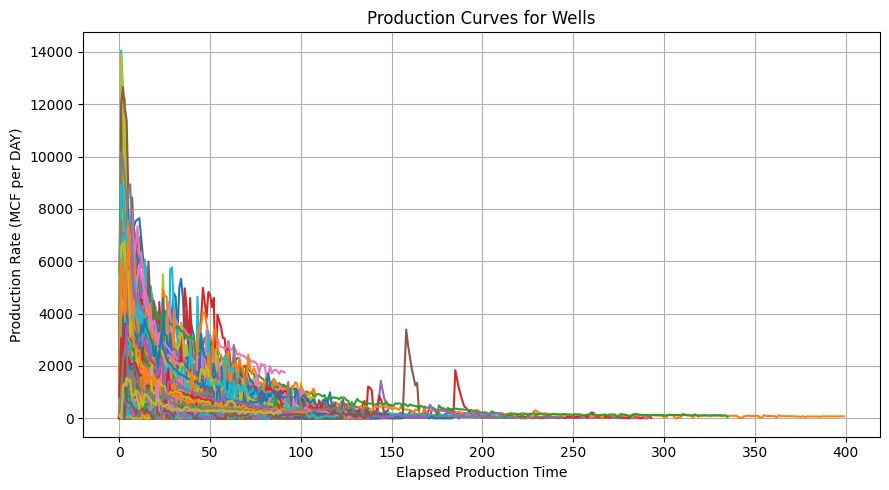

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

# Group data by well identifier (API_UWI)
grouped = df.groupby('API_UWI')  # Replace 'API_UWI' with your well_identifier_col_name if needed
plot_data_bank = []

# Process each well's data
for well_name, group in grouped:
    # Drop missing values, reset index, and prepare the data
    plot_data = group['CDGas_MCFPerDAY'].dropna().reset_index(drop=True)  # Replace 'CDGas_MCFPerDAY' with your y-column name
    plot_data_bank.append((well_name, plot_data))

# Plot production data for each well
plt.figure(figsize=(9, 5))
for well_name, plot_data in plot_data_bank:
    # Use the range of data length for the X-axis
    plot_data_x = list(range(len(plot_data)))
    plt.plot(plot_data_x, plot_data, label=well_name)

# Add plot decorations
plt.xlabel("Elapsed Production Time")  # Replace with dynamic variable if needed (e.g., plot_x_label)
plt.ylabel("Production Rate (MCF per DAY)")  # Replace with dynamic variable if needed (e.g., plot_y_label)
plt.title("Production Curves for Wells")  # Replace with dynamic variable if needed (e.g., plot_title)
plt.grid(True)

# Display the plot
plt.tight_layout()


C:\Users\ziming4\AppData\Local\Temp\ipykernel_8844\1120478845.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['ProducingMonth'] = pd.to_datetime(group['ProducingMonth'])


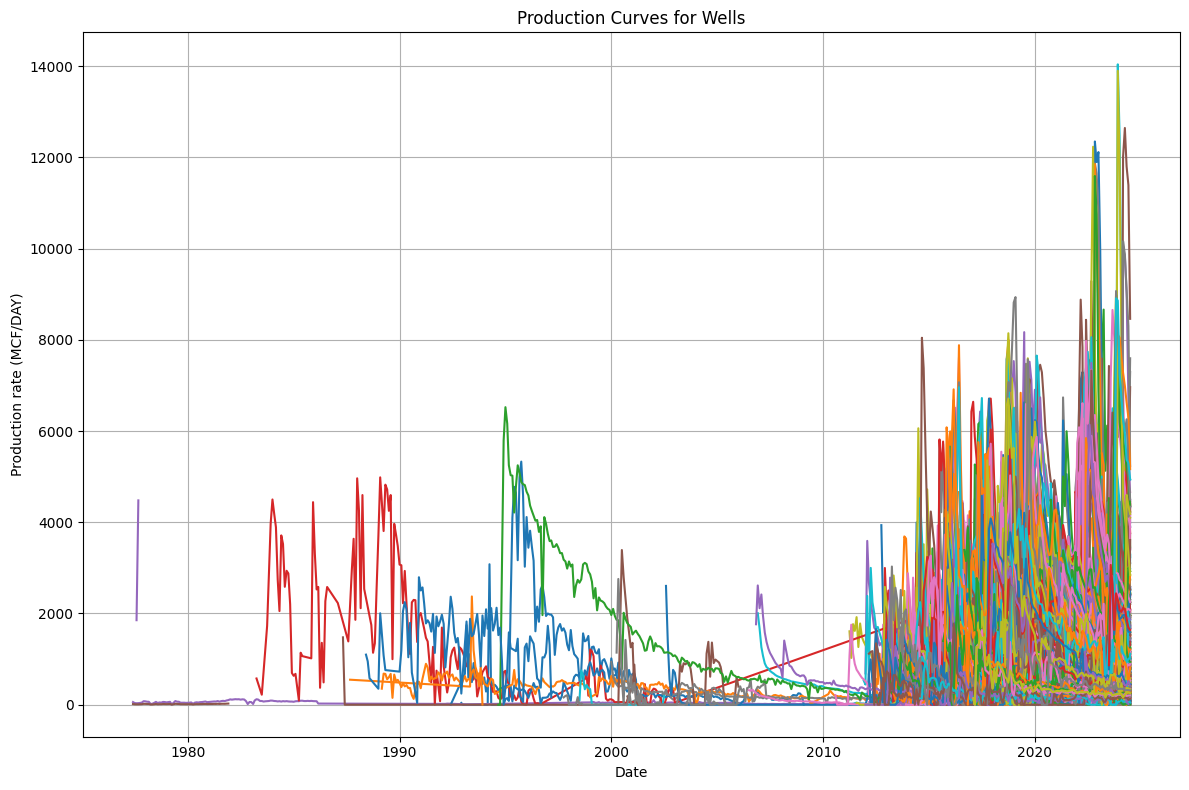

In [46]:
grouped_processed = df.groupby('API_UWI')  # Group by well identifier

plt.figure(figsize=(12, 8))

# Plot the first 10 wells (or fewer if there are fewer groups)
for idx, (well_name, group) in enumerate(grouped_processed):

    # Drop NaN values in critical columns
    group = group.dropna(subset=['ProducingMonth', 'CDGas_MCFPerDAY'])

    # Ensure ProducingMonth is in datetime format and sorted
    group['ProducingMonth'] = pd.to_datetime(group['ProducingMonth'])
    group = group.sort_values(by='ProducingMonth')

    # Plot data
    plt.plot(group['ProducingMonth'], group['CDGas_MCFPerDAY'], label=well_name)

# Add plot decorations
plt.ylabel('Production rate (MCF/DAY)')
plt.xlabel('Date')
plt.title('Production Curves for Wells')
plt.grid(True)
plt.tight_layout()

plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(r'E:\OneDriveCopy\AgentOnlineTest1004\testing production data.csv')

# Assuming df is already defined
plt.figure(figsize=(10, 6))
for well in df['API_UWI'].unique():
    print(well)
    plt.plot(df[df['API_UWI'] == well]['ProducingMonth'],
             df[df['API_UWI'] == well]['CDGas_MCFPerDAY'])

# plt.xlabel('Producing Month')
# plt.ylabel('Gas Rate (MCF/Day)')
# plt.title('Gas Rate for All Wells')
# plt.xticks(rotation=45)
# plt.xticks(rotation=45)
# plt.xticks(ticks=range(0, len(df['ProducingMonth'].unique()), len(df['ProducingMonth'].unique()) // 10))
# plt.tight_layout()

100/01-16-064-16W5/02
100/01-29-062-23W5/00
100/01-31-059-18W5/00
100/03-31-063-21W5/00
100/04-36-055-19W5/02
100/06-09-061-15W5/02
100/07-19-063-18W5/00
100/10-17-064-21W5/02
100/11-22-063-21W5/00
100/13-11-060-18W5/00
100/14-17-064-20W5/00
100/16-05-062-24W5/00
102/08-25-063-22W5/00
102/09-02-063-21W5/00
102/02-09-061-18W5/00
100/03-06-064-19W5/00
100/08-09-062-25W5/00
100/16-36-064-21W5/00
102/08-20-063-19W5/00
103/11-01-062-21W5/02
103/13-23-063-24W5/00
103/02-11-062-20W5/00
103/02-28-060-18W5/00
102/15-04-063-23W5/00
100/05-13-063-20W5/00
100/04-13-062-25W5/00
100/07-13-062-22W5/00
100/08-25-063-22W5/00
100/14-13-063-19W5/00
100/13-26-060-18W5/00
100/13-26-063-20W5/00
100/16-09-062-24W5/00
100/13-09-062-20W5/00
100/16-07-061-16W5/03
103/11-12-062-22W5/00
102/01-18-063-20W5/00
102/04-14-062-19W5/00
100/13-17-065-19W5/00
100/14-28-064-17W5/02
106/10-23-064-22W5/00
100/16-31-062-16W5/00
103/14-03-064-21W5/00
100/11-15-063-23W5/00
100/04-24-065-20W5/00
100/13-20-063-23W5/00
100/15-02-

<Figure size 1000x600 with 0 Axes>

In [24]:
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

class ProcessShutSeqs:
    def __init__(self, shut_threshold = 10, screen_ratio = 0.3, shut_signal=None, peak_t=None):
        self.shut_threshold = shut_threshold
        self.screen_ratio = screen_ratio
        self.shut_signal = shut_signal
        self.peak_t = peak_t
        
    def find_shutins(self, seq):
        # Make a copy of the sequence
        seq_copy = np.copy(seq)

        for i in range(1, len(seq) - 2):
            if seq_copy[i] != 0 and seq_copy[i + 1] != 0:
                q_ratio = np.abs(seq_copy[i + 1] / seq_copy[i])
                if q_ratio <= self.screen_ratio:
                    seq_copy[i + 1] = 0

            if seq_copy[i] != 0 and seq_copy[i + 1] != 0 and seq_copy[i + 2] != 0:
                q_ratio2 = np.abs(seq_copy[i + 2] / seq_copy[i])
                if q_ratio2 <= self.screen_ratio / 2:
                    seq_copy[i + 2] = 0

            if seq_copy[i] < self.shut_threshold:
                seq_copy[i] = 0

        shut_signal = np.copy(seq_copy)
        shut_signal[shut_signal != 0] = 1
        shutins_rev = 1 - shut_signal
        return shutins_rev

        
    def find_peak_t(self, seq):
        peak_t = np.argmax(seq)+1
        return peak_t

    def quality_check(self, seq):
        fixed_seq = np.copy(seq)
        if len(seq) > 1:
            if seq[1] > seq[0]:
                fixed_seq[0] = seq[1]
        elif len(seq) > 2:
            if seq[1] > seq[0] and seq[2] > seq[1]:
                fixed_seq[0] = seq[2]
        elif len(seq) > 3:
            if seq[1] > seq[0] and seq[2] > seq[1] and seq[3] > seq[2]:
                fixed_seq[0] = seq[3]
        return fixed_seq
    
    @staticmethod
    def simple_arps(original_curve, t_extend=None):
        t = np.arange(len(original_curve))  # Assuming time steps are uniform and start from 0
        qi = original_curve[0]  # Initial flow rate

        # Initial guess for Di and b, assuming some typical values for these parameters
        Di_initial_guess = 0.02  # This is a placeholder and should be estimated based on data or given as input
        b_initial_guess = 0.5  # Typical value for hyperbolic decline

        # Define the Arps decline function
        def arps_decline(t, Di, b):
            if b != 0:
                return qi / (1 + b * Di * t) ** (1/b)
            else:
                # For b=0, the formula simplifies to an exponential decline
                return qi * np.exp(-Di * t)

        # Objective function to minimize (mean squared error between the model and actual data)
        def objective(params):
            Di, b = params
            q_predicted = arps_decline(t, Di, b)
            return mean_squared_error(original_curve, q_predicted)

        # Initial parameter guess
        initial_params = [Di_initial_guess, b_initial_guess]

        # Optimization
        result = minimize(objective, initial_params, bounds=[(0.01, 1), (0, 2)])
        Di_opt, b_opt = result.x

        # Predict q using optimized parameters
        if t_extend == None:
            q = arps_decline(t, Di_opt, b_opt)
        else:
            q = arps_decline(np.arange(len(original_curve)+t_extend), Di_opt, b_opt)

        return q, Di_opt, b_opt

    def complex_arps(self, org_seq, t_extend=None):
        segments = []
        start = None
        self.shut_signal = self.find_shutins(org_seq) if self.shut_signal is None else self.shut_signal
        self.peak_t = self.find_peak_t(org_seq) if self.peak_t is None else self.peak_t

        # Identify segments where production occurs (shut_signal == 0)
        for i, signal in enumerate(self.shut_signal):
            if signal == 0 and start is None:
                start = i
            elif signal == 1 and start is not None:
                if i - start >= 1:  # Ensure segment has at least n steps
                    segments.append((start, i))
                start = None
        # Catch any segment that goes to the end of the array
        if start is not None and len(self.shut_signal) - start >= 1:
            segments.append((start, len(self.shut_signal)))

        # Initialize the processed sequence with zeros
        if t_extend is not None:
            extended_length = len(org_seq) + t_extend
        else:
            extended_length = len(org_seq)
            
        processed_seq = np.zeros(extended_length)
        Di_values = np.zeros(extended_length)
        b_values = np.zeros(extended_length)

        # Apply decline analysis to each production segment and update the processed sequence
        n = 0
        for start, end in segments:
            if start <= self.peak_t <= end:
                # If the peak time is within this segment, copy production up to the peak time
                processed_seq[start:self.peak_t] = org_seq[start:self.peak_t]
                
                # Apply decline analysis after the peak time
                prod_segment2 = org_seq[self.peak_t - 1:end]

                if len(segments) == 1:
                    # If there is only one segment, apply decline curve with extension if needed
                    segment_fitted, Di_value, b_value = self.simple_arps(prod_segment2,t_extend)
                    processed_seq[self.peak_t-1:end+t_extend] = segment_fitted
                    Di_values[self.peak_t-1:end+t_extend] = Di_value
                    b_values[self.peak_t-1:end+t_extend] = b_value
                else:
                    # Apply decline curve without extension for multiple segments
                    segment_fitted, Di_value, b_value = self.simple_arps(prod_segment2)
                    processed_seq[self.peak_t - 1:end] = segment_fitted
                    Di_values[self.peak_t - 1:end] = Di_value
                    b_values[self.peak_t - 1:end] = b_value

            else:
                # If no peak within this segment, analyze the entire segment
                prod_segment = org_seq[start:end]
                fixed_rate = self.quality_check(prod_segment)
                
                if n == len(segments)-1 and t_extend is not None: 
                # for the last element, special treat to extend if applies
                    segment_fitted, Di_value, b_value = self.simple_arps(fixed_rate,t_extend)
                    processed_seq[start:end+t_extend] = segment_fitted
                    Di_values[start:end+t_extend] = Di_value
                    b_values[start:end+t_extend] = b_value
                    
                else: 
                    # Standard decline curve fitting without extension
                    segment_fitted, Di_value, b_value = self.simple_arps(fixed_rate)
                    processed_seq[start:end] = segment_fitted
                    Di_values[start:end] = Di_value
                    b_values[start:end] = b_value

                if len(segments) > 1 and n < len(segments) - 1:
                    start_next, _ = segments[n + 1]

                    if end < len(processed_seq):
                        processed_seq[end:start_next] = org_seq[end:start_next]
            n += 1

        return processed_seq, Di_values, b_values

In [63]:
def load_data_to_dataframe(db_name, table_name):
    # Load the entire table into a DataFrame
    conn = sqlite3.connect(db_name)
    df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    conn.close()
    return df

def DCA_tool_table_source(
    table_name: Annotated[str, "The table containing the user's required production data"],
    column_name: Annotated[str, "The column for the desired feature to plot"],
    well_identifier_col_name: Annotated[str, "Column name for well identifier"],
    extend_length: Annotated[Optional[int], "The length by which to extend the forecasted production profile."] = None,
    well_names: Annotated[Optional[List[str]], "Wells to do DCA"] = None,
    All_wells: Annotated[Optional[bool], "Do DCA for all the wells in the file"] = False,
    shut_signal: Annotated[Optional[List[float]], "The signal data for shut-in periods, if applicable."] = None,
    peak_t: Annotated[Optional[int], "The time at which peak production occurs."] = None,
    shut_threshold: Annotated[Optional[float], "Below this rate, the well is considered shut-in."] = 30,
    screen_ratio: Annotated[Optional[float], "Rapid decline threshold. For example, if qt+1/qt < screen_ratio, it will be considered as shut-in."] = 0.1
) -> Annotated[str, "JSON containing the fitted curve, initial decline rate (Di), and b-factor."]:
    """
    Performs Decline Curve Analysis (DCA) using production data sourced from a database table.
    Key Considerations:
    - This DCA tool analyzes data for multiple wells but processes each well individually.
    - Ensure that if the table contains multiple wells, the user specifies which wells to predict.
    - Use the appropriate SQL processing tools to handle data retrieval and manipulation.
    """

    print('========== DCA table source, multiple wells ===========')

    if extend_length is None:
        extend_length = 0

    db_name = r"E:\OneDriveCopy\AgentOnlineTest1004\AgentOnlineTest\backend\database\user_2024_11_20T07_23_34.db"
    df = load_data_to_dataframe(db_name, table_name)

    # Filter Data
    if not All_wells:
        if well_names:
            df = df[df[well_identifier_col_name].isin(well_names)]
        else:
            return json.dumps({
                "message": "Please specify the well names or set All_wells to True."
            })

    if df.empty:
        return json.dumps({
            "message": "No data available for the specified wells."
        })

    # Ensure the specified column is numeric
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')

    # Drop rows with NaN values in the specified column
    df = df.dropna(subset=[column_name])

    if df.empty:
        return json.dumps({
            "message": "No valid data after removing null values."
        })

    # Initialize the result DataFrame
    fit_df = pd.DataFrame()

    # Group the DataFrame by well identifier
    grouped_df = df.groupby(well_identifier_col_name)

    # Process each well individually
    for well_name, group in grouped_df:
        print(well_name)
        well_data = group.copy()

        # Interpolate null values
        well_data[column_name] = well_data[column_name].interpolate(method='linear', limit_direction='forward')

        # Drop remaining NaN values
        well_data = well_data.dropna(subset=[column_name])

        if well_data.empty:
            continue  # Skip wells with no valid data

        # Convert the column to a list of floats
        input_seq = well_data[column_name].tolist()

        # Initialize DCA
        dca = ProcessShutSeqs(
            shut_threshold=shut_threshold,
            screen_ratio=screen_ratio,
            shut_signal=shut_signal,
            peak_t=peak_t
        )

        # Perform DCA
        q_fit, Di_s, b_s = dca.complex_arps(input_seq, extend_length)

        # Prepare the results DataFrame for this well
        result_length = len(q_fit)
        original_length = len(input_seq)

        # Extend well_data to match the length of q_fit
        if result_length > original_length:
            additional_rows = result_length - original_length
            last_date = well_data.index[-1]
            additional_dates = pd.date_range(start=last_date, periods=additional_rows+1, freq='D')[1:]
            additional_df = pd.DataFrame({
                well_identifier_col_name: [well_name] * additional_rows,
                column_name: [np.nan] * additional_rows
            }, index=additional_dates)
            well_data = pd.concat([well_data, additional_df])

        # Add the DCA results to well_data
        well_data['q_fit'] = q_fit
        well_data['Di'] = Di_s
        well_data['b'] = b_s

        # Append the results to the fit_df DataFrame
        fit_df = pd.concat([fit_df, well_data], ignore_index=False)

    if fit_df.empty:
        return json.dumps({
            "message": "DCA could not be performed on any wells due to insufficient data."
        })

    # Store the results back to the database
    conn = sqlite3.connect(db_name)
    fit_df.to_sql(table_name + '_DCA_results', conn, if_exists='replace', index=False)
    conn.commit()
    conn.close()

    # Prepare output to return to the user
    grouped_results = fit_df.groupby(well_identifier_col_name).apply(
        lambda group: {
            "Di": group['Di'].iloc[-1],
            "b": group['b'].iloc[-1]
        }
    ).to_dict()

    output_results = {
        "message": f"DCA successful. The fitted time series is stored in the database table '{table_name}_DCA_results' with the column 'q_fit'.",
        "DCA_results": grouped_results
    }

    return json.dumps(output_results)

In [64]:
import pandas as pd
df = pd.read_csv(r'E:\OneDriveCopy\AgentOnlineTest1004\testing production data.csv')

In [65]:
import ast
user_ID = "user_2024_10_25T18_34_57"
column_name = "CDGas_MCFPerDAY"
well_identifier_col_name = "API_UWI"
table_name = "testing_production_data_multiple_wells"
dca_results = DCA_tool_table_source(table_name = table_name, column_name = column_name, well_identifier_col_name = well_identifier_col_name, All_wells=True, extend_length=36)

========== DCA table source, multiple wells ===========
100/01-16-064-16W5/02
100/01-29-062-23W5/00
100/01-31-059-18W5/00
100/03-06-064-19W5/00
100/03-31-063-21W5/00
100/04-36-055-19W5/02
100/06-09-061-15W5/02
100/07-19-063-18W5/00
100/10-17-064-21W5/02
100/11-22-063-21W5/00
100/13-11-060-18W5/00
100/14-17-064-20W5/00
100/16-05-062-24W5/00
102/02-09-061-18W5/00
102/08-25-063-22W5/00
102/09-02-063-21W5/00


C:\Users\ziming4\AppData\Local\Temp\ipykernel_4480\400924450.py:130: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_results = fit_df.groupby(well_identifier_col_name).apply(


In [61]:
dca_results

'{"message": "DCA successful. The fitted time series is stored in the database table \'testing_production_data_multiple_wells_DCA_results\' with the column \'q_fit\'.", "DCA_results": {"100/01-16-064-16W5/02": {"Di": 0.16174290246224565, "b": 0.08260639869708263}, "100/01-29-062-23W5/00": {"Di": 0.2520311997528442, "b": 2.0}, "100/01-31-059-18W5/00": {"Di": 0.0, "b": 0.0}, "100/03-06-064-19W5/00": {"Di": 0.04856793709821404, "b": 0.6919101883802082}, "100/03-31-063-21W5/00": {"Di": 0.01, "b": 2.0}, "100/04-36-055-19W5/02": {"Di": 0.0, "b": 0.0}, "100/06-09-061-15W5/02": {"Di": 0.22409397778556098, "b": 7.1942019529950246e-09}, "100/07-19-063-18W5/00": {"Di": 0.0, "b": 0.0}, "100/10-17-064-21W5/02": {"Di": 0.01, "b": 2.0}, "100/11-22-063-21W5/00": {"Di": 0.4558213794931209, "b": 0.4747200468940233}, "100/13-11-060-18W5/00": {"Di": 0.4560609781510146, "b": 2.0}, "100/14-17-064-20W5/00": {"Di": 0.0, "b": 0.0}, "100/16-05-062-24W5/00": {"Di": 0.01, "b": 2.0}, "102/02-09-061-18W5/00": {"Di"

In [11]:
def datetime_check(df: pd.DataFrame, 
                                   column_name: Annotated[str, "The column name for the production profile to fit"],
                                   extend_length: Annotated[Optional[int], "The length by which to extend the forecasted production profile."],
                                   datetime_col_name: Annotated[Optional[str], "The datetime column name"]):
    # Convert datetime column to datetime format
    df[datetime_col_name] = pd.to_datetime(df[datetime_col_name])

    # Check 1: Ensure datetime column is in increasing order with consistent steps
    if not df[datetime_col_name].is_monotonic_increasing:
        df = df.sort_values(by=[datetime_col_name, column_name]).reset_index(drop=True)

    # Check 2: Ensure one value per month by averaging if multiple values exist
    df["YearMonth"] = df[datetime_col_name].dt.to_period("M")
    df = df.groupby("YearMonth").agg({column_name: "mean"}).reset_index()
    df[datetime_col_name] = df["YearMonth"].dt.to_timestamp()
    df = df.drop(columns="YearMonth")

    # Check 3: Ensure all months are present, interpolate missing values
    all_months = pd.date_range(start=df[datetime_col_name].min(),
                               end=df[datetime_col_name].max(), freq="MS")
    df = df.set_index(datetime_col_name).reindex(all_months).reset_index()
    df = df.rename(columns={"index": datetime_col_name})
    df[column_name] = df[column_name].interpolate()

    # Check 4: Extend the DataFrame by adding NaN values for the extended length
    if extend_length:
        last_date = df[datetime_col_name].max()
        additional_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1),
                                          periods=extend_length, freq="MS")
        extended_df = pd.DataFrame({datetime_col_name: additional_dates})
        df = pd.concat([df, extended_df], ignore_index=True)

    return df

In [16]:
# Example usage:
data = {
    "datetime": ["2023-01-01", "2023-02-01", "2023-02-15", "2023-03-01"],
    "value": [100, 200, 150, 300],
    "funk": [1, 2, 3, 4],
    "country": ["USA", "USA", "CAN", "CAN"]
}
df = pd.DataFrame(data)

result = datetime_check(df, 
                                        column_name="value", 
                                        extend_length=3, 
                                        datetime_col_name="datetime")


result['wellname'] = 'u001/002'

print(result)

    datetime  value  wellname
0 2023-01-01  100.0  u001/002
1 2023-02-01  175.0  u001/002
2 2023-03-01  300.0  u001/002
3 2023-04-01    NaN  u001/002
4 2023-05-01    NaN  u001/002
5 2023-06-01    NaN  u001/002


In [ ]:
from typing import Annotated, List, Optional
def datetime_check(df: pd.DataFrame, 
                                   column_name: Annotated[str, "The column name for the production profile to fit"],
                                   extend_length: Annotated[Optional[int], "The length by which to extend the forecasted production profile."],
                                   datetime_col_name: Annotated[Optional[str], "The datetime column name"]):
    # Convert datetime column to datetime format
    df[datetime_col_name] = pd.to_datetime(df[datetime_col_name])

    # Check 1: Ensure datetime column is in increasing order with consistent steps
    if not df[datetime_col_name].is_monotonic_increasing:
        df = df.sort_values(by=[datetime_col_name, column_name]).reset_index(drop=True)

    # Check 2: Ensure one value per month by averaging if multiple values exist
    df["YearMonth"] = df[datetime_col_name].dt.to_period("M")
    df = df.groupby("YearMonth").agg({column_name: "mean"}).reset_index()
    df[datetime_col_name] = df["YearMonth"].dt.to_timestamp()
    df = df.drop(columns="YearMonth")

    # Check 3: Ensure all months are present, interpolate missing values
    all_months = pd.date_range(start=df[datetime_col_name].min(),
                               end=df[datetime_col_name].max(), freq="MS")
    df = df.set_index(datetime_col_name).reindex(all_months).reset_index()
    df = df.rename(columns={"index": datetime_col_name})
    df[column_name] = df[column_name].interpolate()

    # Check 4: Extend the DataFrame by adding NaN values for the extended length
    if extend_length:
        last_date = df[datetime_col_name].max()
        additional_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1),
                                          periods=extend_length, freq="MS")
        extended_df = pd.DataFrame({datetime_col_name: additional_dates})
        df = pd.concat([df, extended_df], ignore_index=True)

    return df

def DCA_tool_table_source(
    dfdf: Annotated[pd.DataFrame, "The DataFrame containing the user's required production data"],
    column_name: Annotated[str, "The column name for the production profile to fit"],
    well_identifier_col_name: Annotated[str, "Column name for well identifier"],
    extend_length: Annotated[Optional[int], "The length by which to extend the forecasted production profile."] = None,
    well_names: Annotated[Optional[List[str]], "Wells to do DCA"] = None,
    All_wells: Annotated[Optional[bool], "Do DCA for all the wells in the file"] = False,
    shut_signal: Annotated[Optional[List[float]], "The signal data for shut-in periods, if applicable."] = None,
    peak_t: Annotated[Optional[int], "The time at which peak production occurs."] = None,
    shut_threshold: Annotated[Optional[float], "Below this rate, the well is considered shut-in."] = 10,
    screen_ratio: Annotated[Optional[float], "Rapid decline threshold. For example, if qt+1/qt < screen_ratio, it will be considered as shut-in."] = 0.01,
    is_datetime_col: Annotated[Optional[bool], "Is there a datetime column in the table?"] = False,
    datetime_col_name: Annotated[Optional[str], "The column name for the datatime colume"] = None
) -> Annotated[str, "JSON containing the fitted curve, initial decline rate (Di), and b-factor."]:
    """
    Performs Decline Curve Analysis (DCA) using production data sourced from a database table.
    Key Considerations:
    - This DCA tool analyzes data for multiple wells but processes each well individually.
    - Ensure that if the table contains multiple wells, the user specifies which wells to predict.
    - You MUST check if the table contains a datetime related column.
    - You MUST let the user specific which production data to perform DCA: gas, oil or water.
    - You MUST show the next step message to the user.
    """

    print('========== DCA table source, multiple wells ===========')
    print(well_identifier_col_name)
    print(column_name)

    if extend_length is None:
        extend_length = 0

    df = dfdf

    # Filter Data
    if not All_wells:
        if well_names:
            df = df[df[well_identifier_col_name].isin(well_names)]
            # print(well_names)
        else:
            return json.dumps({
                "message": "Please specify the well names or set All_wells to True."
            })

    if df.empty:
        return json.dumps({
            "message": "No data available for the specified wells."
        })

    # Ensure the specified column is numeric
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')

    # Drop rows with NaN values in the specified column
    df = df.dropna(subset=[column_name])

    # Check empty DataFrame after removing NaN values
    if df.empty:
        return json.dumps({
            "message": "No valid data after removing null values."
        })
    
    # Initialize the result DataFrame, latter the fit_df will only contain the well identifier, datetime (if applicable), original value, fitted value, Di, and b
    fit_df = pd.DataFrame()
    
    # Group the DataFrame by well identifier
    grouped_df = df.groupby(well_identifier_col_name)

    # Process each well individually
    for well_name, group in grouped_df:
        print(f"Processing well: {well_name}")
        print(f'is_datetime_col: {is_datetime_col}')

        # Ceck if there is a datetime column, and if the df[column_name] consistant with the datetime column
        if is_datetime_col:
            print("Processing datetime column")
            group[datetime_col_name] = pd.to_datetime(group[datetime_col_name])
            group_clean = datetime_check(group, column_name, extend_length, datetime_col_name)
        else:
            print("Not processing datetime column")
            group_clean = pd.DataFrame()
            group_clean[column_name] = group[column_name]

        print('====================================')
        print(group_clean)
        print(f"len(group_clean): {len(group_clean)}")
        print("Processing datetime column complete")

        well_data = group_clean.copy()

        # Convert the column to a list of floats
        well_data = well_data.dropna(subset=[column_name])
        input_seq = well_data[column_name].tolist()

        # Initialize DCA
        dca = ProcessShutSeqs(
            shut_threshold=shut_threshold,
            screen_ratio=screen_ratio,
            shut_signal=shut_signal,
            peak_t=peak_t
        )

        # Perform DCA
        q_fit, Di_s, b_s = dca.complex_arps(input_seq, extend_length)

        # Prepare the results DataFrame for this well
        result_length = len(q_fit)
        original_length = len(input_seq)

        if is_datetime_col is False:
            additional_rows = pd.DataFrame({
                column_name: [float('nan')] * (result_length - original_length)
            })
            group_clean = pd.concat([group_clean, additional_rows], ignore_index=True)
            
        # Add the DCA results to the group DataFrame
        q_fit_col_name = 'q_fit_' + column_name
        print(f"len(group_clean): {len(group_clean)}")
        print(f"len(q_fit): {len(q_fit)}")
        group_clean[q_fit_col_name] = q_fit
        group_clean['Di'] = Di_s
        group_clean['b'] = b_s
        group_clean[well_identifier_col_name] = well_name

        # Append the results to the fit_df DataFrame
        fit_df = pd.concat([fit_df, group_clean], ignore_index=False)

    return fit_df

In [51]:
import pandas as pd
import json

# Create synthetic DataFrame
data = {
    "well_id": ["Well_A", "Well_A", "Well_A", "Well_B", "Well_B", "Well_B"],
    "date": [
        "2023-01-01", "2023-02-01", "2023-03-01",
        "2023-01-01", "2023-02-01", "2023-03-01"
    ],
    "production_rate": [20, 90, 85, 120, 115, 110]
}
synthetic_df = pd.DataFrame(data)

# Test input for the function
test_input = {
    "dfdf": synthetic_df,
    "column_name": "production_rate",
    "well_identifier_col_name": "well_id",
    "extend_length": 12,
    "well_names": ["Well_A"],
    "All_wells": False,
    "shut_signal": None,
    "peak_t": None,
    "shut_threshold": 5.0,
    "screen_ratio": 0.05,
    "is_datetime_col": False,
    "datetime_col_name": None
}

# Confirm the synthetic DataFrame
print("Synthetic DataFrame:")
print(synthetic_df)

# Call the function (replace this with your function call and adjust as needed)
# Example:
result = DCA_tool_table_source(**test_input)
result


Synthetic DataFrame:
  well_id        date  production_rate
0  Well_A  2023-01-01               20
1  Well_A  2023-02-01               90
2  Well_A  2023-03-01               85
3  Well_B  2023-01-01              120
4  Well_B  2023-02-01              115
5  Well_B  2023-03-01              110
========== DCA table source, multiple wells ===========
well_id
production_rate
Processing well: Well_A
is_datetime_col: False
Not processing datetime column
   production_rate
0               20
1               90
2               85
len(group_clean): 3
Processing datetime column complete
len(group_clean): 15
len(q_fit): 15


C:\Users\ziming4\AppData\Local\Temp\ipykernel_18688\2356220669.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = pd.to_numeric(df[column_name], errors='coerce')


,production_rate,q_fit_production_rate,Di,b,well_id
0,20.0,20.000000,0.000000,0.00000,Well_A
1,90.0,90.000000,0.057979,0.49786,Well_A
2,85.0,85.000000,0.057979,0.49786,Well_A
3,NaN,80.404850,0.057979,0.49786,Well_A
4,NaN,76.172020,0.057979,0.49786,Well_A
5,NaN,72.264419,0.057979,0.49786,Well_A
6,NaN,68.649585,0.057979,0.49786,Well_A
7,NaN,65.299003,0.057979,0.49786,Well_A
8,NaN,62.187547,0.057979,0.49786,Well_A
9,NaN,59.293006,0.057979,0.49786,Well_A


In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create synthetic data for wells with varying data lengths
data = {
    "API_UWI": ["Well_1"] * 12 + ["Well_2"] * 24 + ["Well_3"] * 18,
    "ProducingMonth": pd.date_range("2020-01-01", periods=12, freq="M").tolist() +
                      pd.date_range("2020-01-01", periods=24, freq="M").tolist() +
                      pd.date_range("2020-01-01", periods=18, freq="M").tolist(),
    "y_col_1": [np.random.randint(50, 100) for _ in range(12)] + 
               [np.random.randint(30, 90) for _ in range(20)] + [np.nan] * 4 +
               [np.random.randint(40, 80) for _ in range(16)] + [np.nan] * 2,
    "y_col_2": [np.random.randint(60, 110) for _ in range(12)] + 
               [np.random.randint(40, 100) for _ in range(24)] + 
               [np.random.randint(50, 90) for _ in range(18)]
}

# Convert to DataFrame
df = pd.DataFrame(data)

C:\Users\ziming4\AppData\Local\Temp\ipykernel_18688\2072236459.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ProducingMonth": pd.date_range("2020-01-01", periods=12, freq="M").tolist() +
C:\Users\ziming4\AppData\Local\Temp\ipykernel_18688\2072236459.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.date_range("2020-01-01", periods=24, freq="M").tolist() +
C:\Users\ziming4\AppData\Local\Temp\ipykernel_18688\2072236459.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pd.date_range("2020-01-01", periods=18, freq="M").tolist(),


In [56]:
df

,API_UWI,ProducingMonth,y_col_1,y_col_2
0,Well_1,2020-01-31,74.0,63
1,Well_1,2020-02-29,77.0,81
2,Well_1,2020-03-31,72.0,73
3,Well_1,2020-04-30,52.0,60
4,Well_1,2020-05-31,71.0,103
5,Well_1,2020-06-30,95.0,92
6,Well_1,2020-07-31,90.0,62
7,Well_1,2020-08-31,79.0,66
8,Well_1,2020-09-30,62.0,87
9,Well_1,2020-10-31,99.0,108


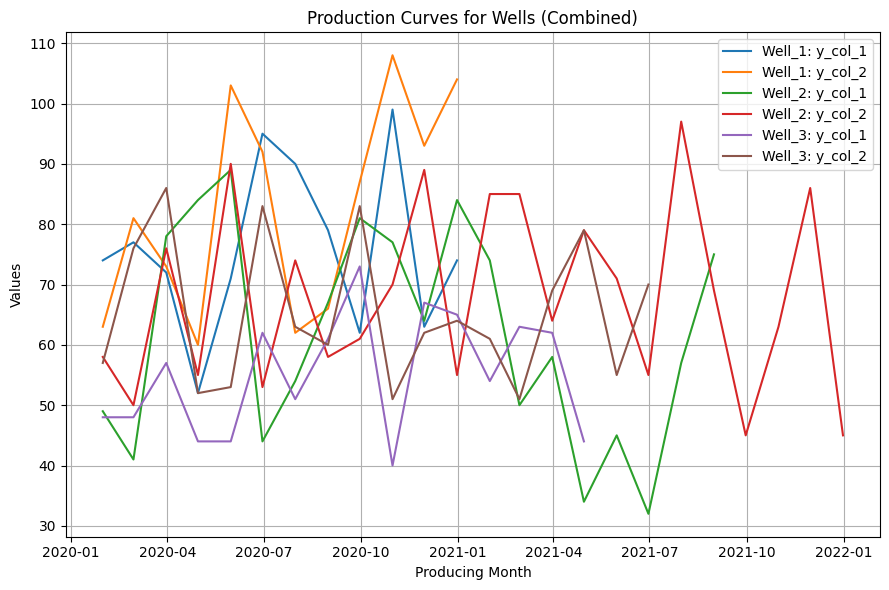

In [62]:
import matplotlib.pyplot as plt
import pandas as pd

# Group data by well identifier (API_UWI)
grouped = df.groupby('API_UWI')

# Define the y_cols to plot
y_cols = ["y_col_1", "y_col_2"]

# Plot production data for each well, with all y_cols on the same plot
plt.figure(figsize=(9, 6))

for well_name, group in grouped:
    # Ensure ProducingMonth is in datetime format and sorted
    group['ProducingMonth'] = pd.to_datetime(group['ProducingMonth'])
    group = group.sort_values(by='ProducingMonth')

    # Plot data for each y_col
    for y_col in y_cols:
        if y_col in group.columns:
            # Drop NaN values for ProducingMonth and the current y_col
            valid_group = group.dropna(subset=['ProducingMonth', y_col])

            # Extract ProducingMonth and y_col data
            producing_month = valid_group['ProducingMonth']
            plot_data = valid_group[y_col]

            # Plot data for the current y_col
            plt.plot(producing_month, plot_data, label=f'{well_name}: {y_col}')

# Add plot decorations
plt.xlabel("Producing Month")
plt.ylabel("Values")
plt.title("Production Curves for Wells (Combined)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot
plt.show()